# Anomaly Detection in  Fiber Networks

## Set Up

### Import Libraries

In [157]:

# -----------------------
# Core / Numerical
# -----------------------
import warnings
import numpy as np
import pandas as pd

from itertools import combinations
from numpy import linalg
from numpy.linalg import norm

# -----------------------
# SciPy / distances
# -----------------------
from scipy.spatial.distance import pdist, squareform

# -----------------------
# Plotting
# -----------------------
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects

# Optional: Seaborn styling with fallback palette
try:
    import seaborn as sns
except ModuleNotFoundError:
    palette = np.array(
        [
            (0.4, 0.7607843137254902, 0.6470588235294118),
            (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
            (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
            (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
            (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
            (1.0, 0.8509803921568627, 0.1843137254901961),
            (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
            (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
        ]
    )
else:
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = np.array(sns.color_palette("Set2"))

# -----------------------
# Scikit-learn
# -----------------------
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    pairwise_distances,
    precision_score,
    recall_score,
    roc_auc_score,
    silhouette_score,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, scale
from sklearn.svm import SVC, OneClassSVM
from sklearn.utils import shuffle, resample 

# -----------------------
# PennyLane (Quantum ML)
# -----------------------
import pennylane as qml
import pennylane.numpy as pnp
from pennylane.kernels import kernel_matrix, square_kernel_matrix
from pennylane.optimize import NesterovMomentumOptimizer


# -----------------------
# Misc
# -----------------------
warnings.filterwarnings("ignore")


In [158]:
# Random state
RS = 42
pnp.random.seed(RS)

### Data Pre-Processing

In [159]:
data = pd.read_csv("epb_fiber_dataset.csv")
data.head()

,timestamp,segment_id,region_code,link_type,vendor,maintenance_flag,latency_ms,latency_jitter_ms,packet_loss_pct,error_rate,reset_count,throughput_util_pct,traffic_period
0,2026-01-01T00:00:00,SEG-008,Downtown,Access,VendorA,0,11.324225,2.106861,0.118247,0.000077,0,45.960570,overnight
1,2026-01-01T00:15:00,SEG-007,Industrial,Access,VendorC,0,8.632439,2.030257,0.000000,0.000000,0,37.190357,overnight
2,2026-01-01T00:30:00,SEG-028,Downtown,Backbone,VendorA,0,14.679951,0.721178,0.077039,0.000000,0,67.903547,overnight
3,2026-01-01T00:45:00,SEG-039,Downtown,Aggregation,VendorC,0,13.848729,0.244006,0.045327,0.000228,0,58.770968,overnight
4,2026-01-01T01:00:00,SEG-035,East,Backbone,VendorC,0,11.249959,0.721537,0.095630,0.000000,0,58.467407,overnight


Sk-Learn makes it extremely easy to split a dataframe into a train and test det of X (features) and y (targets/labels)

In [160]:
# Check the number of unique categories before one hot encoding

unique_tperiod = data['traffic_period'].nunique()
unique_ltype = data['link_type'].nunique()
unique_region = data['region_code'].nunique()
unique_vendor = data['traffic_period'].nunique()
unique_segment = data['segment_id'].nunique()

print(unique_tperiod)
print(unique_ltype)
print(unique_region)
print(unique_vendor)
print(unique_segment)


4
3
7
4
40


In [161]:
# Seperate Col Types
cat_cols = ["region_code", "link_type", "vendor", "traffic_period"]
num_cols = ["latency_ms", "latency_jitter_ms", "packet_loss_pct", "error_rate", "reset_count", "throughput_util_pct"]

# Create Encoder
encoder = OneHotEncoder(sparse_output = False)

# Fit + Transform
encoded = encoder.fit_transform(data[cat_cols])

encoded_data = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(cat_cols), index=data.index)

In [162]:
# Create PCA
def pca_df(col_names, df):
    pca = PCA(n_components=1, random_state=20150101)
    X_pca = pca.fit_transform(df[col_names])

    X_pca_df = pd.DataFrame(
        X_pca,
        index=df.index
    )

    return X_pca_df

In [163]:
# Group Columns

region_cols = ['region_code_Downtown', 'region_code_East', 'region_code_Industrial',
       'region_code_North', 'region_code_South', 'region_code_Suburban',
       'region_code_West']


link_cols = ['link_type_Access', 'link_type_Aggregation',
       'link_type_Backbone']

vendor_cols = ['vendor_VendorA', 'vendor_VendorB',
       'vendor_VendorC']


traffic_cols = ['traffic_period_afternoon', 'traffic_period_evening',
       'traffic_period_morning', 'traffic_period_overnight']

num_cols = ["latency_ms", "latency_jitter_ms", "packet_loss_pct", "error_rate", "reset_count", "throughput_util_pct", "maintenance_flag"]



# Create Data Frames

region_df = pca_df(region_cols, encoded_data)
link_df = pca_df(link_cols, encoded_data)
vendor_df = pca_df(vendor_cols, encoded_data)
traffic_df = pca_df(traffic_cols, encoded_data)
numeric_df = data[num_cols]


# Rename 
region_df = region_df.rename(columns={0: "Regions"})
link_df = link_df.rename(columns={0: "Links"})
vendor_df = vendor_df.rename(columns={0: "Vendors"})
traffic_df = traffic_df.rename(columns={0: "Traffic"})


# Combine Data
final_df = pd.concat([region_df, link_df, vendor_df, traffic_df, numeric_df], axis = 1)

In [164]:
final_df.head()

,Regions,Links,Vendors,Traffic,latency_ms,latency_jitter_ms,packet_loss_pct,error_rate,reset_count,throughput_util_pct,maintenance_flag
0,-0.268392,-0.640731,-0.198501,-0.707107,11.324225,2.106861,0.118247,0.000077,0,45.960570,0
1,-0.064007,-0.640731,0.750753,-0.707107,8.632439,2.030257,0.000000,0.000000,0,37.190357,0
2,-0.268392,-0.465591,-0.198501,-0.707107,14.679951,0.721178,0.077039,0.000000,0,67.903547,0
3,-0.268392,0.662155,0.750753,-0.707107,13.848729,0.244006,0.045327,0.000228,0,58.770968,0
4,-0.156992,-0.465591,0.750753,-0.707107,11.249959,0.721537,0.095630,0.000000,0,58.467407,0


In [165]:
features = final_df.drop("maintenance_flag", axis=1)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(features)


ready_df = pd.DataFrame(
    scaled_df,
    index=final_df.index,
    columns = features.columns
)

## QSVM Implementation


### Feature Reduction

Simulating a quantum support vector machine with many features is difficult, so I will reduce the number of features with three different methods and compare.

In [166]:
# Create PCA
def pca2_df(col_names, df):
    pca = PCA(n_components=.95, random_state=RS)
    X_pca = pca.fit_transform(df[col_names])

    X_pca_df = pd.DataFrame(
        X_pca,
        index=df.index
    )

    return X_pca_df

In [167]:
# Use PCA to generate a completely black box data set
selected_cols = ['Regions', 'Links', 'Vendors', 'latency_ms',
       'latency_jitter_ms', 'packet_loss_pct', 'error_rate', 'reset_count',
       'throughput_util_pct']



PCA_df = pca2_df(selected_cols, ready_df)
PCA_df = pd.concat([PCA_df, data['maintenance_flag']], axis = 1)


# Result of a Grid Search (Classical Kernel Comparisons)
grid_search_df = ready_df[['Vendors', 'latency_ms', 'Regions']]
grid_search_df = pd.concat([grid_search_df, data['maintenance_flag']], axis = 1)



# Hand Selected Features
hand_selected_df = ready_df[['Regions', 'Links', 'latency_ms', 'latency_jitter_ms', 'error_rate', 'reset_count']]
hand_selected_df = pd.concat([hand_selected_df, data['maintenance_flag']], axis = 1)

### Testing

#### DF 1

In [168]:
from sklearn.utils import resample

# PCA Train Test Set UP
PCA_features = PCA_df[[0, 1, 2, 3, 4, 5]]
labels = PCA_df['maintenance_flag']

label_array = labels.to_numpy()
PCA_feature_array = PCA_features.to_numpy()

x_down1, y_down1 = resample(PCA_feature_array, label_array, n_samples=800, replace=False, random_state=RS)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_down1, y_down1, test_size = .3, stratify=y_down1, random_state=RS)

print(x_train_1.shape)
print(x_train_1[0].shape)


(560, 6)
(6,)


In [169]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_1.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [170]:
PCA_kernel_train = square_kernel_matrix(x_train_1, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_1, x_train_1, kernel=quantum_kernel)




In [171]:
# Train the SVM
clf1 = SVC(kernel='precomputed', class_weight='balanced')
clf1.fit(PCA_kernel_train, y_train_1)

y_pred = clf1.predict(PCA_kernel_test)

In [172]:
# Metrics
y_scores = clf1.decision_function(PCA_kernel_test)
roc_auc = roc_auc_score(y_test_1, y_scores)
pr_auc = average_precision_score(y_test_1, y_scores)
precision = precision_score(y_test_1, y_pred, average='binary')
recall = recall_score(y_test_1, y_pred, average='binary')
f1 = f1_score(y_test_1, y_pred, average='binary')
accuracy = accuracy_score(y_test_1, y_pred)

print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

ROC AUC: 0.6174178244662827
PR AUC: 0.09242897022398162
Precision: 0.08571428571428572
Recall: 0.46153846153846156
F1 Score: 0.14457831325301204
Accuracy: 0.7041666666666667


#### Df 2

In [173]:
# Grid Train Test Set UP
grid_features = grid_search_df[["Vendors", "latency_ms", "Regions"]]
labels = grid_search_df['maintenance_flag']

label_array = labels.to_numpy()
grid_feature_array = grid_features.to_numpy()

x_down2, y_down2 = resample(grid_feature_array, label_array, n_samples=800, replace=False, random_state=RS)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_down2, y_down2, test_size = .3, stratify=y_down2, random_state=RS)

print(x_train_2.shape)
print(x_train_2[0].shape)

(560, 3)
(3,)


In [174]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_1.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [175]:
grid_kernel_train = square_kernel_matrix(x_train_2, kernel=quantum_kernel)
grid_kernel_test = kernel_matrix(x_test_2, x_train_2, kernel=quantum_kernel)

In [176]:
# Train the SVM
clf2 = SVC(kernel='precomputed', class_weight='balanced')
clf2.fit(grid_kernel_train, y_train_2)

y_pred = clf.predict(grid_kernel_test)

# Metrics
y_scores = clf2.decision_function(grid_kernel_test)
roc_auc = roc_auc_score(y_test_2, y_scores)
pr_auc = average_precision_score(y_test_2, y_scores)
precision = precision_score(y_test_2, y_pred, average='binary')
recall = recall_score(y_test_2, y_pred, average='binary')
f1 = f1_score(y_test_2, y_pred, average='binary')
accuracy = accuracy_score(y_test_2, y_pred)

print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

ROC AUC: 0.4781430023720773
PR AUC: 0.06849034080497264
Precision: 0.08045977011494253
Recall: 0.5384615384615384
F1 Score: 0.14
Accuracy: 0.6416666666666667


#### Df 3

In [177]:
# Manual Train Test Set UP

manual_features = hand_selected_df[['Regions', 'Links', 'latency_ms', 'latency_jitter_ms', 'error_rate', 'reset_count']]
labels = hand_selected_df['maintenance_flag']

label_array = labels.to_numpy()
manual_feature_array = manual_features.to_numpy()

x_down3, y_down3 = resample(manual_feature_array, label_array, n_samples=800, replace=False, random_state=RS)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_down3, y_down3, test_size = .3, stratify=y_down3, random_state=RS)

print(x_train_3.shape)
print(x_train_3[0].shape)

(560, 6)
(6,)


In [178]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_1.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [179]:
manual_kernel_train = square_kernel_matrix(x_train_3, kernel=quantum_kernel)
manual_kernel_test = kernel_matrix(x_test_3, x_train_3, kernel=quantum_kernel)

In [180]:
# Train the SVM
clf3 = SVC(kernel='precomputed', class_weight='balanced')
clf3.fit(manual_kernel_train, y_train_3)

y_pred = clf3.predict(manual_kernel_test)

# Metrics
y_scores = clf3.decision_function(manual_kernel_test)
roc_auc = roc_auc_score(y_test_3, y_scores)
pr_auc = average_precision_score(y_test_3, y_scores)
precision = precision_score(y_test_3, y_pred, average='binary')
recall = recall_score(y_test_3, y_pred, average='binary')
f1 = f1_score(y_test_3, y_pred, average='binary')
accuracy = accuracy_score(y_test_3, y_pred)

print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

ROC AUC: 0.5306675703151474
PR AUC: 0.0774543348121896
Precision: 0.06976744186046512
Recall: 0.46153846153846156
F1 Score: 0.12121212121212122
Accuracy: 0.6375


## Result Analysis

In [181]:
# Visualization Functions for Later

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    classification_report,
    confusion_matrix,
)

def evaluate_kernel_and_get_pr(
    clf,             # fitted classifier (e.g., OneClassSVM or SVC)
    K_test,          # test kernel (precomputed) or X_test features
    y_test,          # true labels (0/1)
    label,           # name to show in legend (e.g., 'Quantum kernel A')
    positive_label=1 # which label is "positive" (anomaly)
):
    """
    Returns PR curve points and the Average Precision (PR AUC).
    For OCSVM/SVC with precomputed kernels, pass K_test. For normal SVC, pass X_test.
    """
    # Scores: decision_function preferred (monotonic with margin).
    if hasattr(clf, "decision_function"):
        y_scores = clf.decision_function(K_test)
    elif hasattr(clf, "predict_proba"):
        # Use positive class probability if available
        y_scores = clf.predict_proba(K_test)[:, 1]
    else:
        raise ValueError("Classifier must implement decision_function or predict_proba.")

    # PR curve and Average Precision (area under PR curve)
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=positive_label)
    ap = average_precision_score(y_test, y_scores, pos_label=positive_label)

    # Optionally compute point metrics using default threshold (sign of score)
    y_pred = (y_scores >= 0).astype(int) if set(np.unique(y_test)) == {0,1} else None

    metrics = {}
    if y_pred is not None:
        cm = confusion_matrix(y_test, y_pred, labels=[0,1])
        report = classification_report(y_test, y_pred, digits=4)
        metrics = {"confusion_matrix": cm, "report": report}

    return {
        "label": label,
        "precision": precision,
        "recall": recall,
        "ap": ap,
        "y_scores": y_scores,
        "metrics": metrics,
    }

def plot_multiple_pr_curves(pr_results, y_test, title="Precision–Recall curves (Anomaly Detection)", figsize=(8,6), positive_label=1):
    """
    pr_results: list of dicts returned by evaluate_kernel_and_get_pr
    """
    plt.figure(figsize=figsize)

    # Baseline: positive class prevalence (expected precision of random classifier)
    pos_rate = (y_test == positive_label).mean()
    plt.hlines(pos_rate, xmin=0, xmax=1, colors="gray", linestyles="--", label=f"Baseline (prevalence={pos_rate:.3f})")

    # Plot each kernel’s PR curve
    for res in pr_results:
        plt.plot(
            res["recall"],
            res["precision"],
            lw=2,
            label=f"{res['label']} (AP={res['ap']:.4f})"
        )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 0.5])
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.title(title, fontsize=13)
    plt.legend(loc="upper right", frameon=True)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


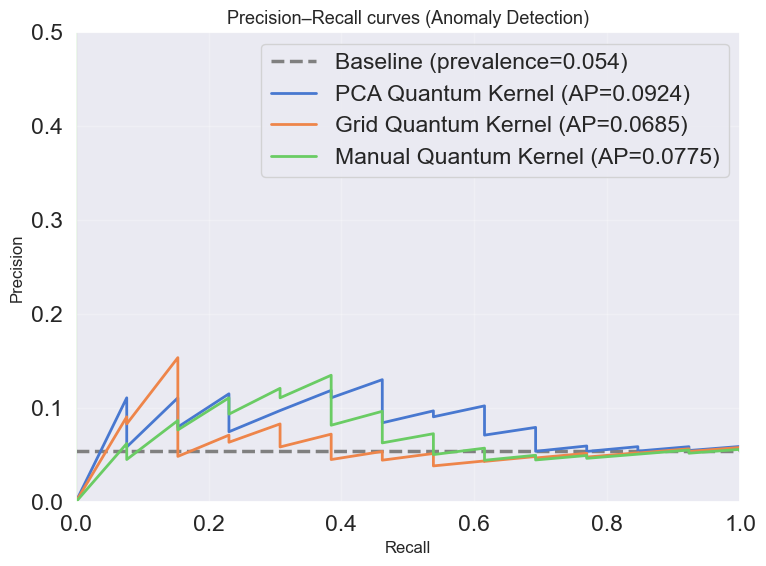

In [182]:
# Resuls

resA = evaluate_kernel_and_get_pr(
    clf1,             # fitted classifier (e.g., OneClassSVM or SVC)
    PCA_kernel_test,          # test kernel (precomputed) or X_test features
    y_test_1,          # true labels (0/1)
    'PCA Quantum Kernel',           # name to show in legend (e.g., 'Quantum kernel A')
    positive_label=1 # which label is "positive" (anomaly)
)


resB = evaluate_kernel_and_get_pr(
    clf2,             # fitted classifier (e.g., OneClassSVM or SVC)
    grid_kernel_test,          # test kernel (precomputed) or X_test features
    y_test_2,          # true labels (0/1)
    'Grid Quantum Kernel',           # name to show in legend (e.g., 'Quantum kernel A')
    positive_label=1 # which label is "positive" (anomaly)
)

resC = evaluate_kernel_and_get_pr(
    clf3,             # fitted classifier (e.g., OneClassSVM or SVC)
    manual_kernel_test,          # test kernel (precomputed) or X_test features
    y_test_3,          # true labels (0/1)
    'Manual Quantum Kernel',           # name to show in legend (e.g., 'Quantum kernel A')
    positive_label=1 # which label is "positive" (anomaly)
)


results = [resA, resB, resC]
plot_multiple_pr_curves(results, y_test_1, title="Precision–Recall curves (Anomaly Detection)", figsize=(8,6), positive_label=1)

For sake of analysis on performance that pennylane results produce we will create a user defined function to evaluate the kernels average precision. 